Dataset shape: (1259, 27)

Columns: ['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments']
Age groups created:
Age_Group
Adult (26-35)     709
Middle (36-45)    277
Young (18-25)     217
Senior (45+)       56
Name: count, dtype: int64
Found support-related columns: ['benefits', 'care_options', 'wellness_program']
Categorical columns to encode: ['Timestamp', 'Gender', 'Country', 'state', 'self_employed']
Timestamp: 1246 unique values
Gender: 3 unique values
Country: 48 unique values
state: 45 unique values
self_employed: 2 unique values
✅ Label encoded self_employed
family_history: 2 unique values
✅ Label encoded 

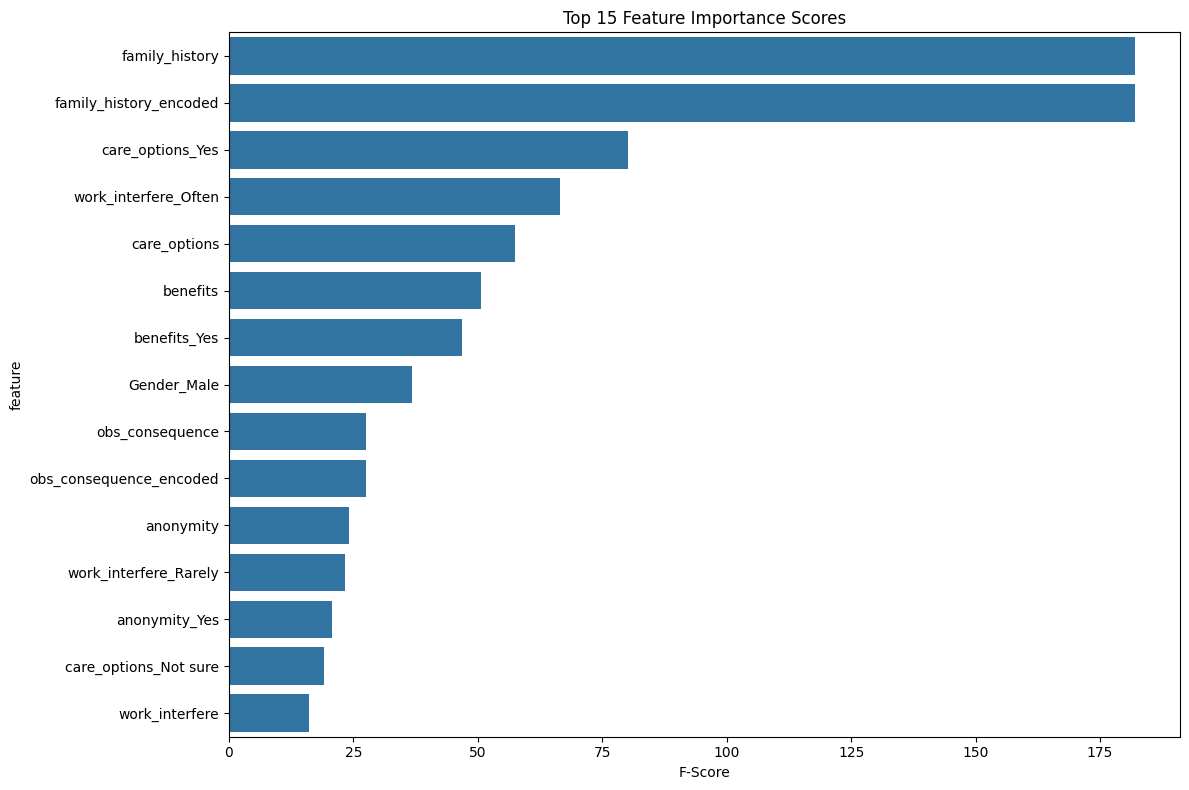

✅ All processed data and encoders saved!
Training data shape: (1007, 21)
Test data shape: (252, 21)
Complete data shape: (1259, 71)
FEATURE ENGINEERING SUMMARY:
1. Original features: 27
2. After encoding: 72
3. Final selected features: 20
4. Feature reduction: 72.2%

Binary features encoded: 5
Multi-class features one-hot encoded: 16

Top 5 most important features:
1. family_history: 181.95
2. family_history_encoded: 181.95
3. care_options_Yes: 80.16
4. work_interfere_Often: 66.55
5. care_options: 57.56

✅ Feature Engineering completed!
Next step: Model Training


In [2]:
# ============================================================
# feature_engineering.py
# ============================================================
# Feature Engineering Script for Mental Health in Tech Survey Dataset
# Handles feature creation, encoding, scaling, and selection.
# ============================================================

# 1. Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import warnings

warnings.filterwarnings('ignore')

# 2. Load cleaned dataset
df = pd.read_csv('../data/processed/cleaned_mental_health_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

df_fe = df.copy()

# 3. Create Age Groups
if 'Age' in df_fe.columns:
    df_fe['Age_Group'] = pd.cut(
        df_fe['Age'],
        bins=[0, 25, 35, 45, 100],
        labels=['Young (18-25)', 'Adult (26-35)', 'Middle (36-45)', 'Senior (45+)']
    )
    print("Age groups created:")
    print(df_fe['Age_Group'].value_counts())

# 4. Create derived features from existing columns (if applicable)
support_columns = [
    col for col in df_fe.columns if any(keyword in col.lower()
    for keyword in ['benefits', 'wellness', 'care', 'resources', 'leave'])
]

if support_columns:
    print(f"Found support-related columns: {support_columns[:3]}")
    # Placeholder for domain-specific feature creation
    pass

# 5. Encode categorical variables
categorical_columns = df_fe.select_dtypes(include=['object']).columns.tolist()

if 'treatment' in categorical_columns:
    categorical_columns.remove('treatment')

print(f"Categorical columns to encode: {categorical_columns[:5]}")

label_encoders = {}
encoded_df = df_fe.copy()
binary_features = []

for col in categorical_columns:
    unique_values = df_fe[col].nunique()
    print(f"{col}: {unique_values} unique values")

    if unique_values == 2:
        le = LabelEncoder()
        encoded_df[col + '_encoded'] = le.fit_transform(df_fe[col])
        label_encoders[col] = le
        binary_features.append(col)
        print(f"✅ Label encoded {col}")

print(f"\nBinary features encoded: {binary_features}")

# 6. One-hot encode multi-class categorical variables
multi_class_features = [
    col for col in categorical_columns if 2 < df_fe[col].nunique() <= 10
]
print(f"Multi-class features for one-hot encoding: {multi_class_features}")

if multi_class_features:
    for col in multi_class_features:
        dummies = pd.get_dummies(df_fe[col], prefix=col, drop_first=True)
        encoded_df = pd.concat([encoded_df, dummies], axis=1)
        print(f"✅ One-hot encoded {col} - created {len(dummies.columns)} new features")

print(f"\nDataset shape after encoding: {encoded_df.shape}")

# 7. Encode target variable
if 'treatment' in encoded_df.columns:
    target_encoder = LabelEncoder()
    encoded_df['treatment_encoded'] = target_encoder.fit_transform(encoded_df['treatment'])

    print("Target variable encoding:")
    treatment_mapping = dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))
    print(treatment_mapping)

    os.makedirs('../models', exist_ok=True)
    joblib.dump(target_encoder, '../models/target_encoder.pkl')
    print("✅ Target encoder saved")

# 8. Separate features and target
feature_columns = [col for col in encoded_df.columns if col not in ['treatment', 'treatment_encoded']]
X = encoded_df[feature_columns]

if 'treatment_encoded' in encoded_df.columns:
    y = encoded_df['treatment_encoded']
elif 'treatment' in encoded_df.columns:
    y = encoded_df['treatment']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {feature_columns[:10]}...")

# 9. Handle any remaining non-numeric columns
# 7. Handle any remaining non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

if non_numeric_cols:
    print(f"Found non-numeric columns before scaling: {non_numeric_cols}")

    for col in non_numeric_cols:
        if X[col].dtype == 'object' or str(X[col].dtype).startswith('category'):
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
            print(f"✅ Label encoded non-numeric column: {col}")

# Verify again that all columns are numeric
print(f"\nAll features numeric? {X.select_dtypes(include=[np.number]).shape[1] == X.shape[1]}")


# 10. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("Features scaled using StandardScaler")
print(f"Scaled features shape: {X_scaled.shape}")

joblib.dump(scaler, '../models/feature_scaler.pkl')
print("✅ Feature scaler saved")

# 11. Feature selection using statistical methods
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

k_best = min(20, X_train.shape[1])
selector = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = X.columns[selector.get_support()].tolist()
feature_scores = selector.scores_[selector.get_support()]

print(f"\nSelected {len(selected_features)} features out of {X.shape[1]}")
print(f"Selected features: {selected_features[:10]}...")

# 12. Feature importance visualization
if len(selected_features) > 0:
    feature_importance_df = pd.DataFrame({
        'feature': selected_features,
        'score': feature_scores
    }).sort_values('score', ascending=False)

    print("Top 10 most important features:")
    print(feature_importance_df.head(10))

    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    sns.barplot(data=top_features, x='score', y='feature')
    plt.title('Top 15 Feature Importance Scores')
    plt.xlabel('F-Score')
    plt.tight_layout()
    plt.show()

# 13. Save processed data
X_train_df = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_df = pd.DataFrame(X_test_selected, columns=selected_features)

train_data = X_train_df.copy()
train_data['target'] = y_train.values
train_data.to_csv('../data/processed/train_data.csv', index=False)

test_data = X_test_df.copy()
test_data['target'] = y_test.values
test_data.to_csv('../data/processed/test_data.csv', index=False)

complete_data = pd.DataFrame(X_scaled, columns=X.columns)
complete_data['target'] = y.values
complete_data.to_csv('../data/processed/complete_processed_data.csv', index=False)

with open('../data/processed/selected_features.json', 'w') as f:
    json.dump(selected_features, f)

joblib.dump(label_encoders, '../models/label_encoders.pkl')
joblib.dump(selector, '../models/feature_selector.pkl')

print("✅ All processed data and encoders saved!")
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Complete data shape: {complete_data.shape}")

# 14. Summary
print("FEATURE ENGINEERING SUMMARY:")
print("=" * 50)
print(f"1. Original features: {df.shape[1]}")
print(f"2. After encoding: {encoded_df.shape[1]}")
print(f"3. Final selected features: {len(selected_features)}")
print(f"4. Feature reduction: {((encoded_df.shape[1] - len(selected_features)) / encoded_df.shape[1] * 100):.1f}%")
print(f"\nBinary features encoded: {len(binary_features)}")
print(f"Multi-class features one-hot encoded: {len(multi_class_features)}")

print("\nTop 5 most important features:")
if len(selected_features) > 0:
    for i, (feature, score) in enumerate(zip(feature_importance_df['feature'][:5], feature_importance_df['score'][:5])):
        print(f"{i+1}. {feature}: {score:.2f}")

print("\n✅ Feature Engineering completed!")
print("Next step: Model Training")
